In [1]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures



# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- HOUSE: https://fred.stlouisfed.org/series/HSN1F
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [3]:
"""
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key
# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())


# Generate a date range from January 1950 to the present
date_range = date_range = pd.date_range(start='1950', end='2024', freq='M')

# Create Original data frame, wich Date, Year, Month columns
df_origin = pd.DataFrame({'Date': date_range})
df_origin['Year'] = df_origin['Date'].dt.year
df_origin['Month'] = df_origin['Date'].dt.month


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left')


# Download S&P500 data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()
# Add the close prices of S&P500 on each month
df_origin['SP500'] = sp500[sp500['Date'] >= '1950-01-31']['Close']

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

[*********************100%***********************]  1 of 1 completed


,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1950-01-31,1950,1,NaN,23.51,NaN,NaN,NaN,6.5,17.049999
1,1950-02-28,1950,2,NaN,23.61,NaN,NaN,NaN,6.4,17.219999
2,1950-03-31,1950,3,NaN,23.64,NaN,NaN,NaN,6.3,17.290001
3,1950-04-30,1950,4,NaN,23.65,NaN,NaN,NaN,5.8,17.959999
4,1950-05-31,1950,5,NaN,23.77,NaN,NaN,NaN,5.5,18.780001


In [6]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.tail()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
883,2023-08-31,2023,8,4.09,306.269,69.4,99.9799,676.0,3.8,4507.660156
884,2023-09-30,2023,9,4.59,307.481,67.9,100.3412,759.0,3.8,4288.049805
885,2023-10-31,2023,10,4.86,NaN,NaN,NaN,NaN,NaN,4117.370117
886,2023-11-30,2023,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,2023-12-31,2023,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Clearning & Modification

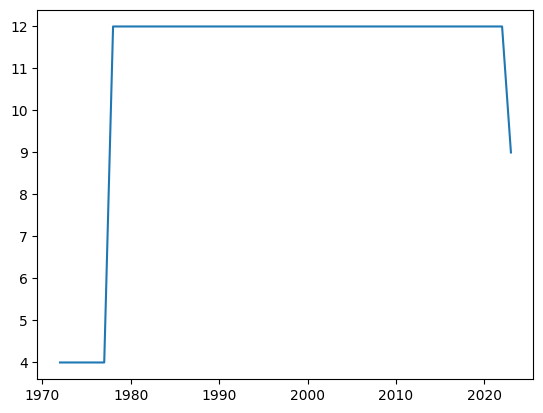

In [7]:
# dropping rows based on any missing data
df = df_origin.dropna()

# groupby dataframe based on "Year" and check the count
group_year = df.groupby('Year').count()[['Date']]
plt.plot(group_year.index, group_year.values.flatten())

In [8]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1978-01-31,1978,1,7.94,62.7,83.7,43.7471,795.0,6.4,89.250000
1,1978-02-28,1978,2,8.04,63.0,84.3,43.9139,791.0,6.3,87.040001
2,1978-03-31,1978,3,8.15,63.4,78.8,44.6899,814.0,6.3,89.209999
3,1978-04-30,1978,4,8.24,63.9,81.6,45.3905,864.0,6.1,96.830002
4,1978-05-31,1978,5,8.42,64.5,82.9,45.6235,857.0,6.0,97.239998


In [9]:
# Create categorical data;
#  whether the S&P500 rises (1) or falls(0) compared to a year ago
cat_values = (df['SP500'] > df['SP500'].shift(12)).astype(int)
cat_values[:12] = None
df['SP500_RISE'] = cat_values

# Changes to %YoY
chg_YoY = ['CPI', 'CSENT', 'IPM', 'HOUSE', 'SP500']
df.loc[:, chg_YoY] = df[chg_YoY].pct_change(12) * 100

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500,SP500_RISE
0,1979-01-31,1979,1,8.95,9.250399,-13.859020,7.862464,-5.157233,5.9,11.966387,1.0
1,1979-02-28,1979,2,9.17,9.841270,-12.336892,7.786828,-8.596713,5.9,10.615806,1.0
2,1979-03-31,1979,3,9.11,10.252366,-13.197970,6.418676,-2.579853,5.8,13.877365,1.0
3,1979-04-30,1979,4,9.35,10.485133,-19.117647,2.997984,-13.425926,5.8,5.091398,1.0
4,1979-05-31,1979,5,9.06,10.697674,-17.852835,3.917937,-15.169195,5.6,1.892230,1.0


In [10]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(888, 10)  ->  (537, 11)

Total Missing Valies:
827  ->  0


In [11]:
# basic statistics (original)
features = ['SP500', 'MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']
df_origin[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,886.000000,742.000000,885.000000,641.000000,621.000000,729.000000,885.000000
mean,776.709221,5.874730,122.272904,85.583619,74.246268,655.824417,5.733672
std,1033.585855,2.992385,83.730383,12.880524,23.720226,208.354422,1.711406
min,17.049999,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000
25%,88.822500,3.852500,34.700000,76.100000,50.371500,515.000000,4.400000
50%,248.285004,5.630000,110.400000,89.300000,81.839900,628.000000,5.500000
75%,1211.747528,7.635000,193.600000,95.000000,98.334700,765.000000,6.800000
max,4766.180176,15.840000,307.481000,112.000000,106.420200,1389.000000,14.700000


In [12]:
# basic statistics (current)
df[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,10.054631,5.771248,3.522074,0.424961,1.885628,1.541610,6.114525
std,15.914452,3.389501,2.758007,13.496403,4.903644,19.985430,1.781144
min,-44.756241,0.550000,-1.958761,-41.520468,-19.513084,-50.534759,3.400000
25%,2.044136,2.940000,1.897448,-6.589958,-0.241347,-10.873016,4.800000
50%,11.739275,5.070000,2.843915,0.281690,2.353977,2.729885,5.700000
75%,19.609019,8.020000,4.129264,6.723586,4.722677,13.576159,7.200000
max,53.714506,15.840000,14.592275,47.582205,20.819818,88.200590,14.700000


# Data Observation

### Correlation Matrix

In [13]:
# correlation Matrix
df[features].corr()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
SP500,1.000000,0.040169,-0.019967,0.419536,0.397708,0.379114,0.024833
MY10Y,0.040169,1.000000,0.592219,0.131505,0.159661,-0.106524,0.281223
CPI,-0.019967,0.592219,1.000000,-0.229663,0.023801,-0.361605,0.008175
CSENT,0.419536,0.131505,-0.229663,1.000000,0.298721,0.404598,0.174768
IPM,0.397708,0.159661,0.023801,0.298721,1.000000,0.133935,-0.237187
HOUSE,0.379114,-0.106524,-0.361605,0.404598,0.133935,1.000000,0.138328
UNEMP,0.024833,0.281223,0.008175,0.174768,-0.237187,0.138328,1.000000


### Feature Reduction

In [14]:
# create a new feature and insert it 
df.insert(loc=9, column='LRIR', value=df['MY10Y'] - df['CPI'])

# drop MY10Y and CPI
df.drop(['MY10Y', 'CPI'], axis=1, inplace=True)

# show new dimension
print("New Dimension: ", df.shape)

# show new correlation matrix
features = ['SP500','CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
df[features].corr()

New Dimension:  (537, 10)


,SP500,CSENT,IPM,HOUSE,UNEMP,LRIR
SP500,1.000000,0.419536,0.397708,0.379114,0.024833,0.067510
CSENT,0.419536,1.000000,0.298721,0.404598,0.174768,0.380992
IPM,0.397708,0.298721,1.000000,0.133935,-0.237187,0.167885
HOUSE,0.379114,0.404598,0.133935,1.000000,0.138328,0.224626
UNEMP,0.024833,0.174768,-0.237187,0.138328,1.000000,0.328568
LRIR,0.067510,0.380992,0.167885,0.224626,0.328568,1.000000


### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


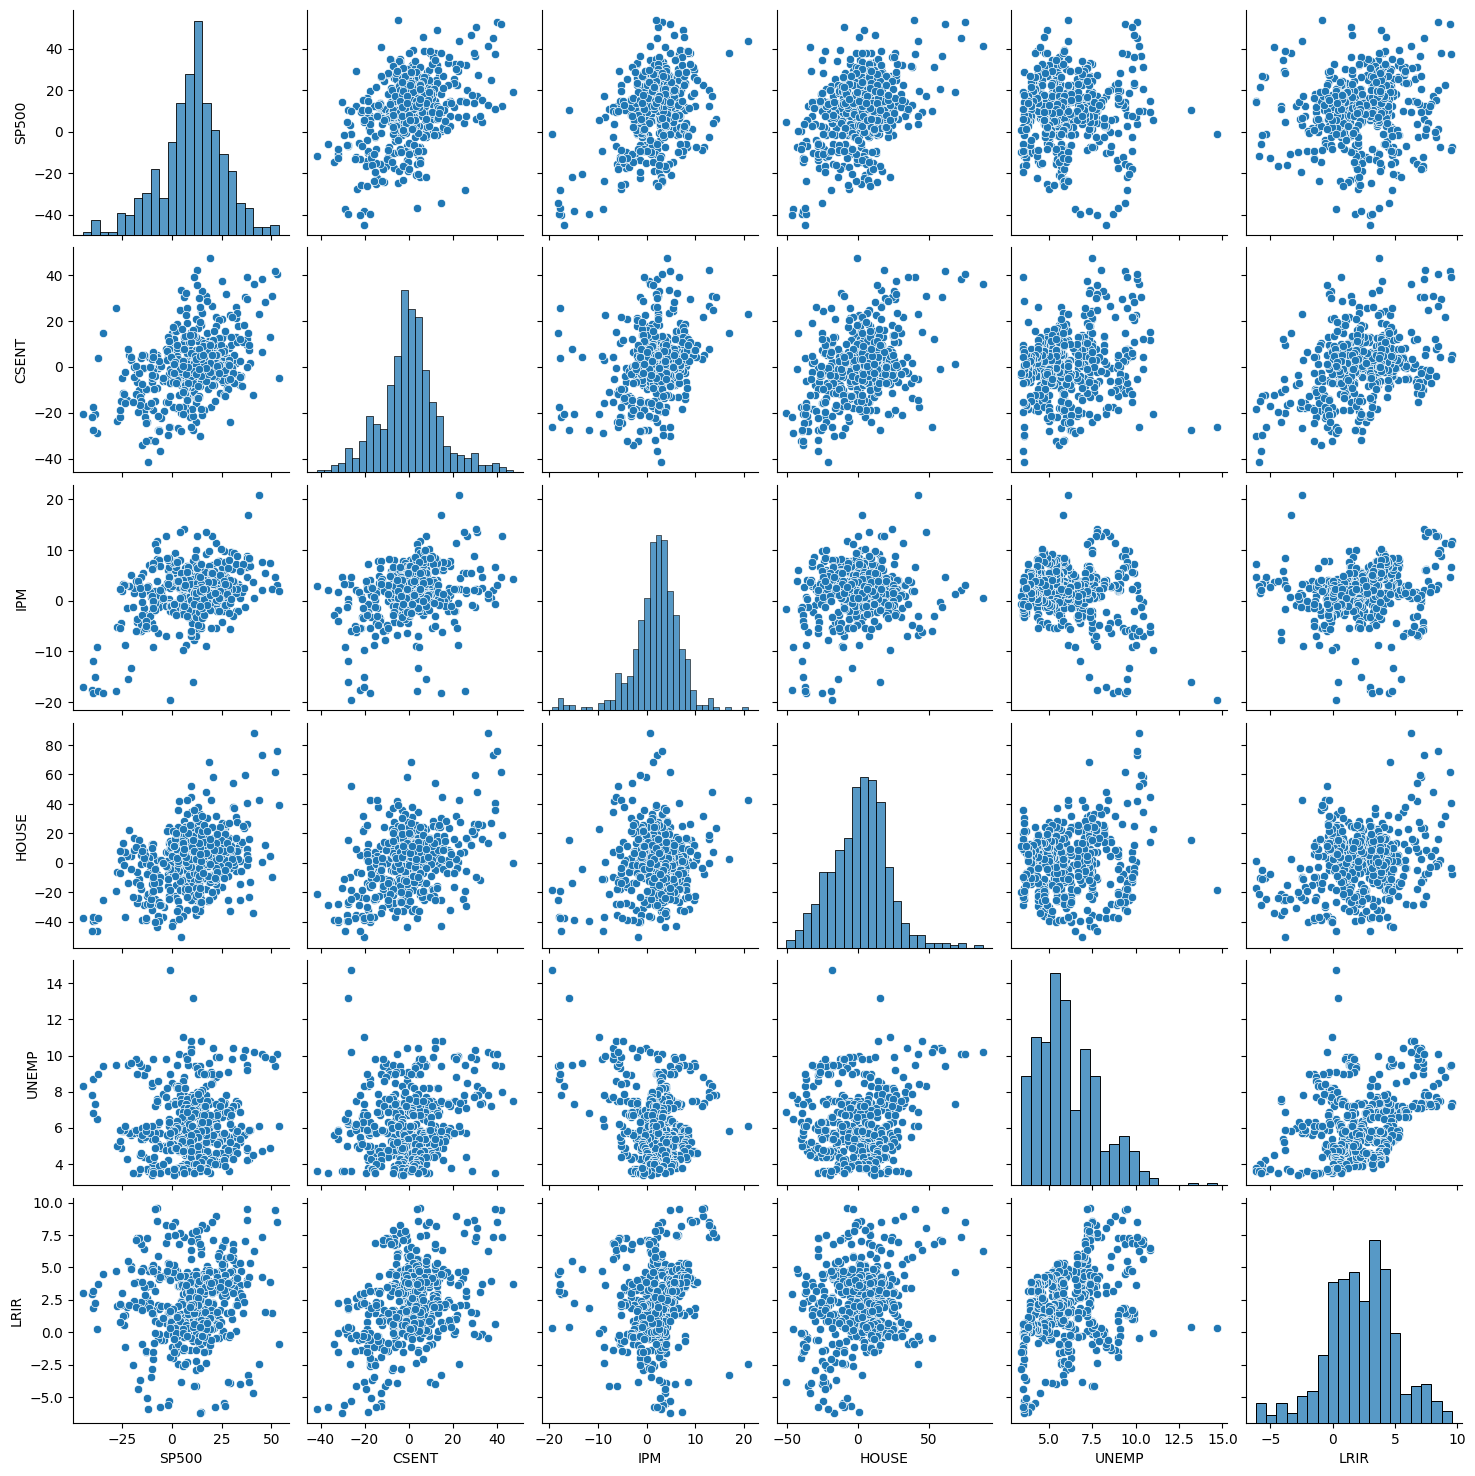

In [11]:
# check correlation 
sns.pairplot(df[features])

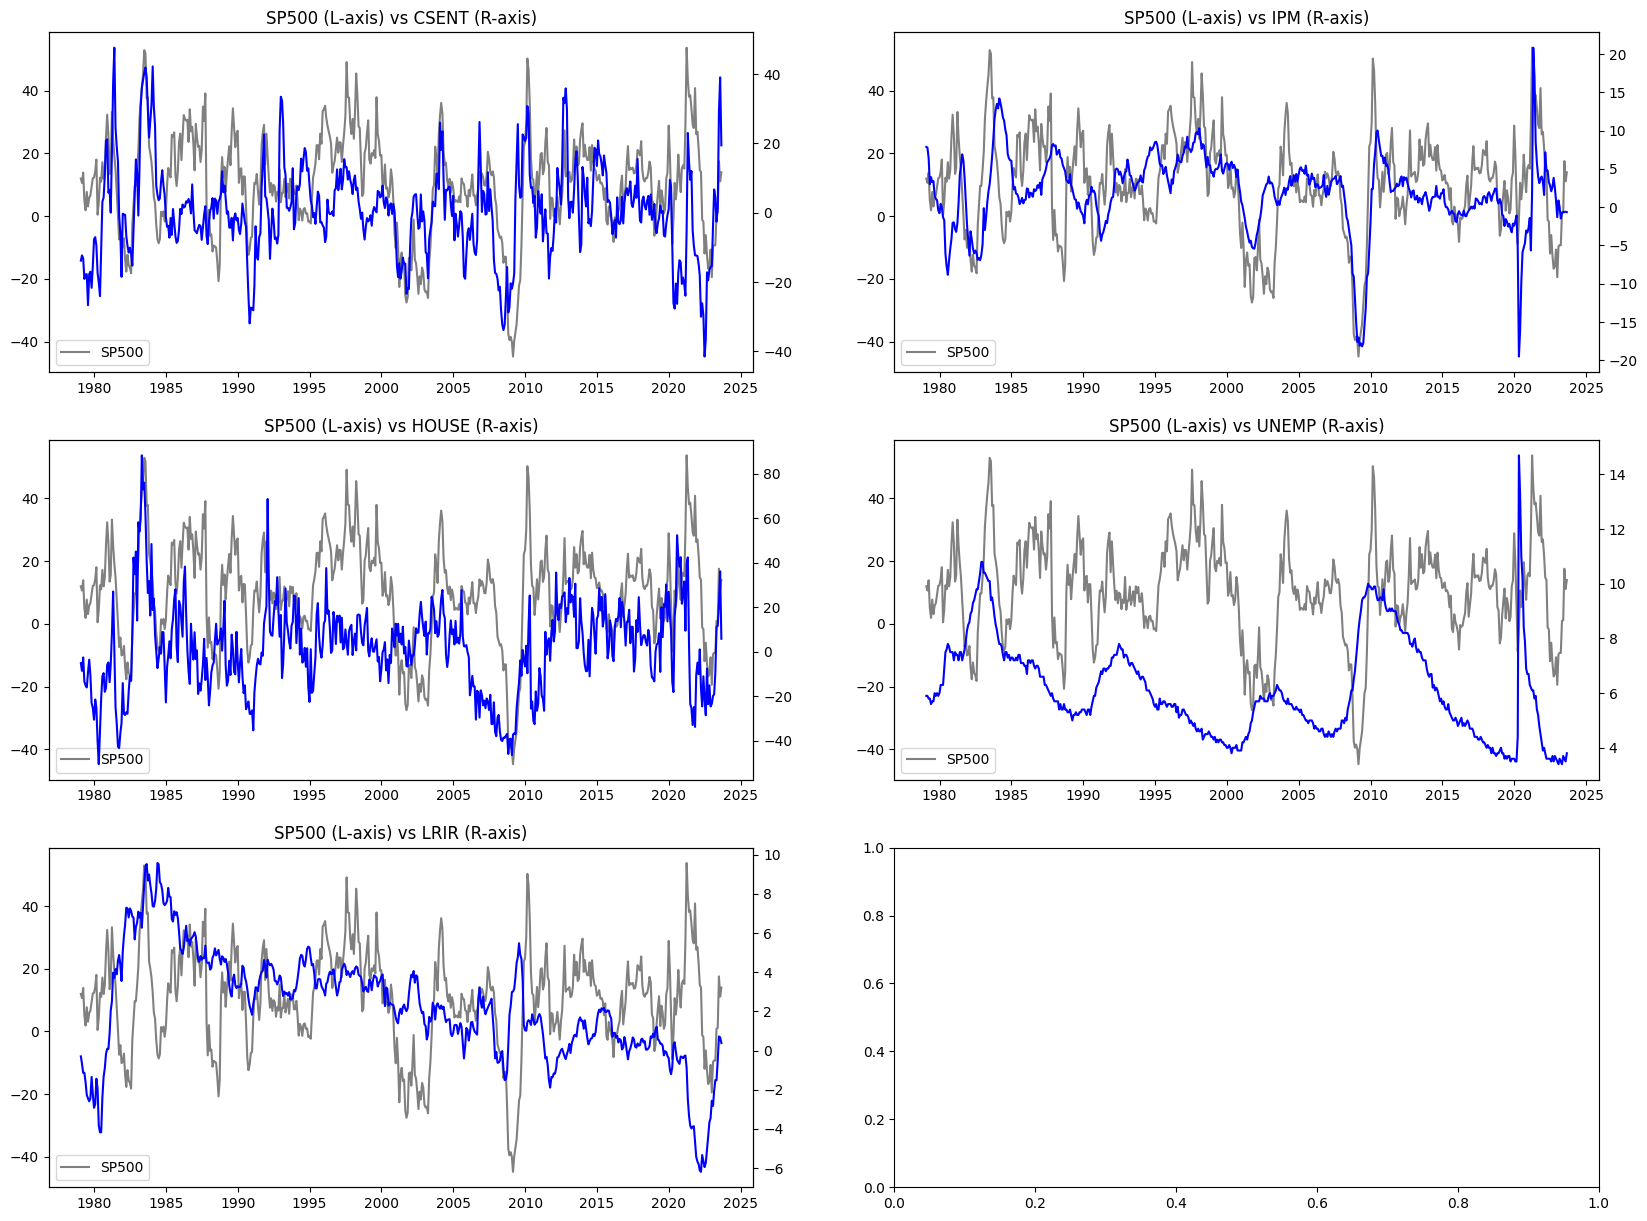

In [ ]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))

for idx, d in enumerate(features[1:]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"SP500 (L-axis) vs {d} (R-axis)")
    ax[i][j].legend()


C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


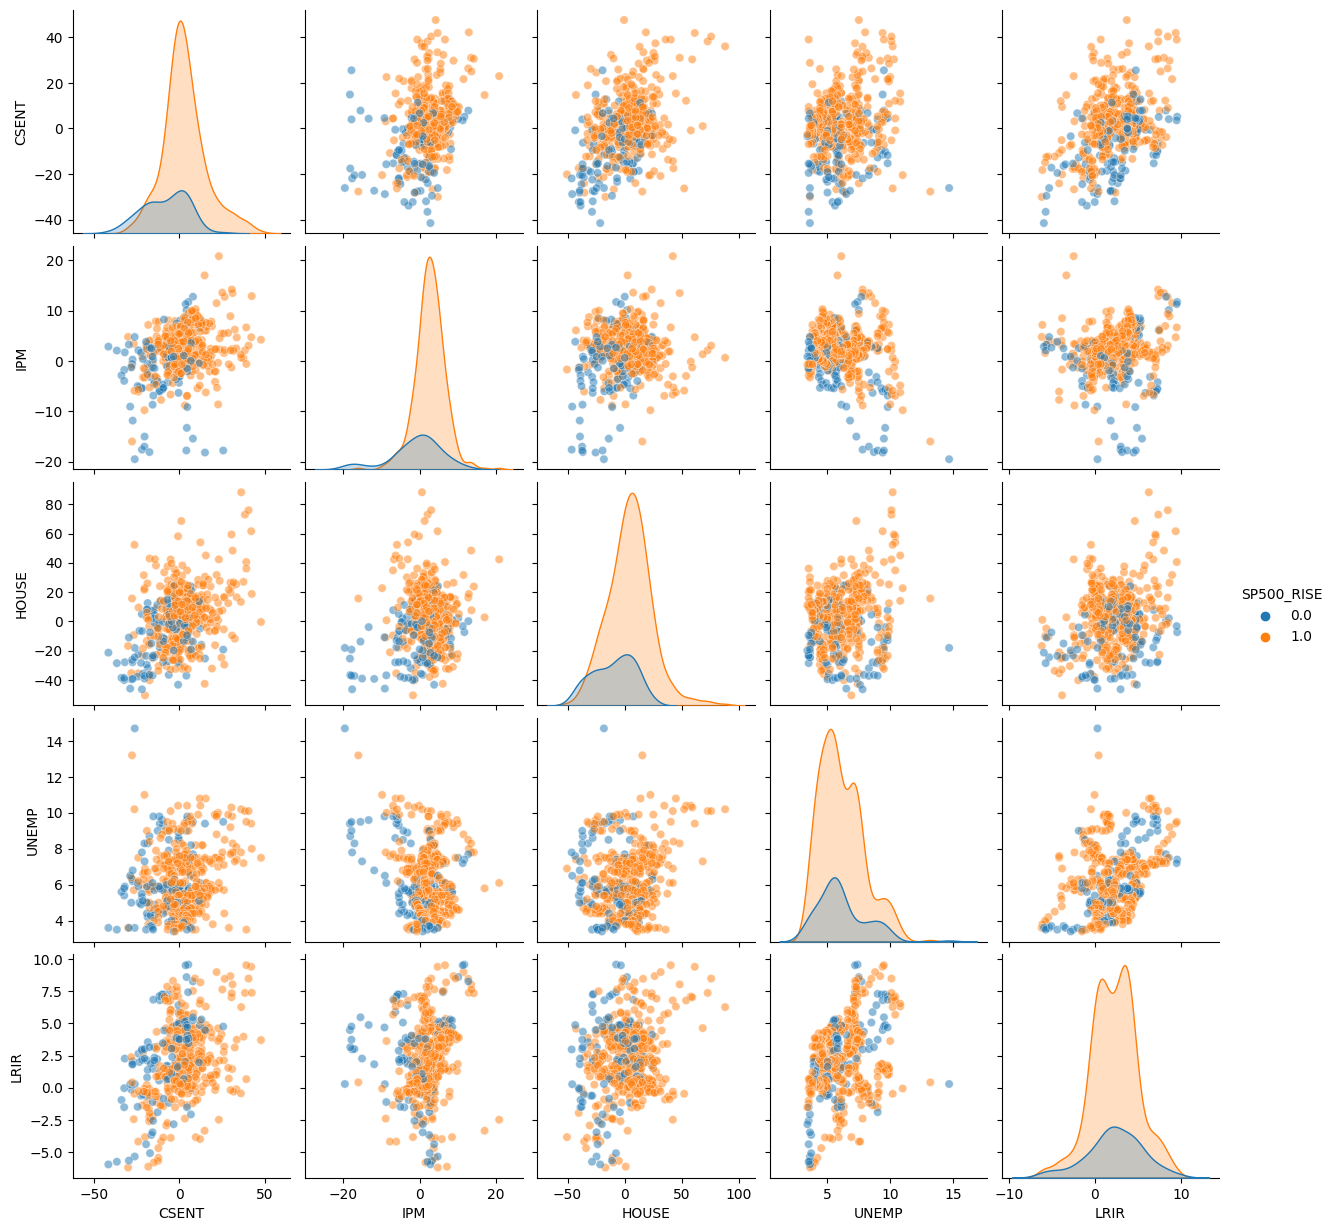

In [ ]:
# Check the pairs (two independent variables) of the scatter plots based on the categorical data.
indicators = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
sns.pairplot(df[indicators + ['SP500_RISE']], hue='SP500_RISE', plot_kws={'alpha': 0.5})

Text(0.5, 0.98, 'Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

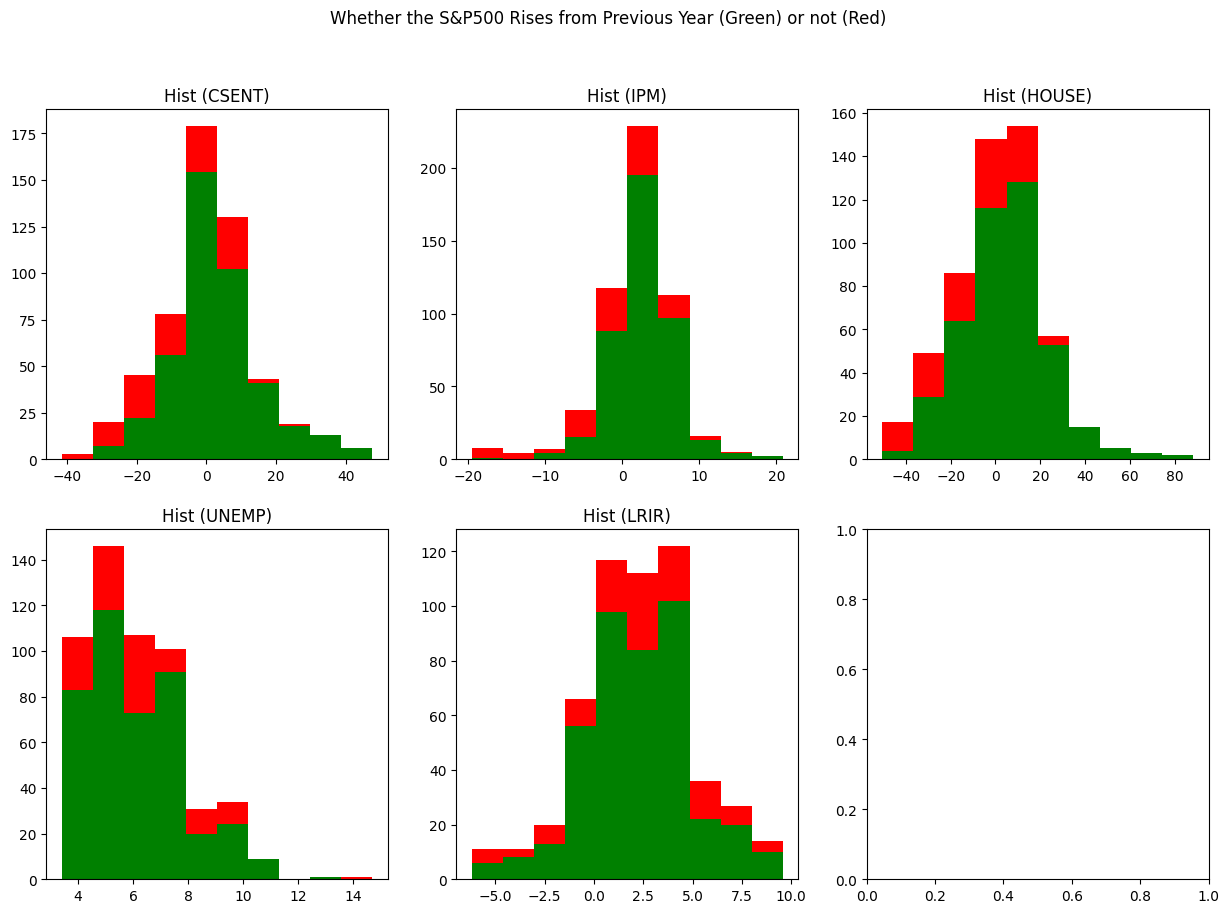

In [ ]:
# Check histogram of each independent variable based on the ratio of categorical data.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, data in enumerate(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']):
    i1, i2 = i // 3, i % 3
    rise = df[df['SP500_RISE'] == 1.0][data]
    fall = df[df['SP500_RISE'] == 0.0][data]
    ax[i1][i2].hist([rise, fall], color=['green', 'red'], stacked=True)
    ax[i1][i2].set_title(f'Hist ({data})')

plt.suptitle('Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

# Dataset Creation
- Four types of moving averages ; 1-, 3-, 6-, 12-month.
- Four types of dataset shifts; 0-, 1-, 2-, 3-month.


# Model Creation & Evaluation

- Four machine learning models
    1. Multiple Linear Regression
    2. Non-Multiple Linear Regression
    3. Logistic Regression
    4. Classification and Regression Tree

<br>

- Evaluations
    - Regressions:
        - <b>Root Mean Square Error (RMSE)</b>: How much errors could occur between the predicted prices and the actual ones.
        - <b>Standard Error of Estimate (SE)</b>: How much variation could occur in the actual target based on the same condition of independent variables. 
        - <b>Coffeficient of Determination (R2)</b>: How well the regression model explains the variation of a target value.<br><br>
        
    - Classification
        - <b>Accuracy</b>: How the model can correctly predict the target values.
        - <b></b>
        - <b></b>

### Multiple linear Regression
- Applying different scopes for parameter adjustments; [1, 6, 12, 36]
- Feature selection by backward elimination for whole models.

In [15]:
from Functions import Regression, Standardization

In [78]:
class Regression_test:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        # initialize other variables
        self.X_name = []
        self.y_name = ''
        self.ma_opts = []
        self.fp_opts = []
        self.datasets = {}

        self.scopes = []
        self.results = {}
        self.be_tests = {'ma': {}, 'sc': {}}
        self.perf_df = pd.DataFrame(data=[], columns=['SC', 'MA', 'FP', 'RMSE', 'SE', 'R2', 'Adj-R2'])

        # initialize class
        self.poly = None
        self.scaler = None
        
        # css style for sub title
        self.SUB_CSS = 'style="font-size: 12.5px; color: lightgrey;"'

    def create_data(self, X_n: list, y_n: str, ma: list, fp: list, poly_d: int = 1):
        """
        Create the datasets -> self.datasets: dict

        Parameters:
        - "X_n": input feature names
        - "y_n": target value name
        - "ma": moving average options for a target value
        - "fp": options of future prediction (month basis);
                 how many months of target values are predictd based on current data.
        - "poly_degree": degree of the polynomials
        """
        # update variables
        self.y_name = y_n
        self.ma_opts = ma
        self.fp_opts = fp

        # start creating data
        y = np.array(self.df[[y_n]])
        for ma_i in self.ma_opts:
            # apply moving averages (ma is 0 or 1 -> no moving averages)
            if ma_i < 2:
                y_ma_i = y
                ma_i = 1
            else:
                #X_ma_i = np.array([np.mean(X[i-ma_i:i], axis=0) for i in range(ma_i, len(X))])
                y_ma_i = np.array([np.mean(y[i-ma_i:i], axis=0) for i in range(ma_i, len(y))])
            
            # apply polynomial
            self.poly = PolynomialFeatures(degree=poly_d, include_bias=True)
            X_poly = self.poly.fit_transform(self.df[X_n])
            # store all X names after polynomial transform
            self.X_name = self.poly.get_feature_names_out()
            
            # standardization
            self.scaler = Standardization()
            X_ss = self.scaler.fit_transform(120, X_poly[ma_i:, 1:])
            # add bias term
            X_ss_b = np.c_[np.ones(X_ss.shape[0]), X_ss]

            # apply data shift
            for fp_i in self.fp_opts:
                self.datasets.update({f"{ma_i}MA_{fp_i}M": {'X': X_ss_b, 'y': y_ma_i[fp_i:]}})


    def model_result(self, scopes: list, model_name: str = '', eta: float = 0.01, alpha: float = 1.0, lambda_: float = 0.5):
        # set spaces
        self.be_tests['ma'].update({ma: [] for ma in self.ma_opts})
        
        for i, s in enumerate(scopes):
            # set spaces
            self.results[s] = {}
            self.be_tests['sc'].update({s: []})

            # each dataset
            for j, d_key in enumerate(self.datasets.keys()):
                idx = i * len(self.datasets.keys()) + j
                data = self.datasets[d_key]
                theta, y_hat, error = self.gradient_descent(
                    X=data['X'], y=data['y'], t=120, s=s, 
                    eta=eta, alpha=alpha, lambda_=lambda_
                )
                # store all data
                self.results[s].update({d_key: {'theta': theta, 'y_hat': y_hat, 'error': error}})
                # get test result of backward elimination
                be_test_df = self.evaluation(data['X'], data['y'], 120, theta, y_hat, error)
                # retrienve only performance without any changes in each coefficient
                ma, fp = d_key.split('_')
                ma_int = int(re.findall(r'\d+', ma)[0])
                self.perf_df.loc[idx] = [s, ma_int, fp] + list(be_test_df.iloc[0])
                # store its result as NDArray
                self.be_tests['sc'][s].append(np.array(be_test_df))
                ma_idx = self.ma_opts[j // len(self.fp_opts)]
                self.be_tests['ma'][ma_idx].append(np.array(be_test_df))

        
        self.compere_perf_fig = self.compare_perf(model_name)
        self.be_test_sc_fig = self.backward_elimination('sc')
        self.be_test_ma_fig = self.backward_elimination('ma')

        return self.compere_perf_fig, self.be_test_sc_fig, self.be_test_ma_fig




    def detail_perf(self, ma: int, fp: int, sc: int):
        """
        Return two plotly chart:
        - Line chart: Comparing the predicted and actual value.
        - Mix chart:  Distribution of the predicted errors by histogram and scatter plots.

        Return: plotly.graph_objs._figure.Figure

        """
        # get model and data
        d_name = f'{ma}MA_{fp}M'
        data = self.datasets[d_name]
        theta, y_hat, error = tuple(self.results[sc][d_name].values())
        
        # number of observations
        num_obs = len(y_hat)
        date = self.df['Date'][-num_obs:].values
        actual = data['y'][-num_obs:].flatten()
        predict = y_hat.flatten()

        # Figure 01 - Line Chart
        fig1 = go.Figure()
        x_date = pd.to_datetime(date)
        fig1.add_trace(go.Scatter(x=x_date, y=actual, mode='lines', name='Actual'))
        fig1.add_trace(go.Scatter(x=x_date, y=predict, mode='lines', name='Predict',
                                line=dict(color='lightgreen')))

        # future value
        if fp > 0:
            y, m = x_date[-1].year, x_date[-1].month - 1
            months = [(i % 12) + 1 for i in range(m, m+fp+1)]
            add_on = []
            for i, month in enumerate(months):
                # update the year
                if i != 1 and month == 1:
                    y += 1
                add_on.append(str(pd.Timestamp(y, month, 1) + pd.offsets.MonthEnd(1)).split()[0])
            new_X = data['X'][num_obs:]
            future = np.dot(new_X, theta[-1].reshape(-1,1)).flatten()
            fig1.add_trace(go.Scatter(
                x=pd.to_datetime(add_on), y=np.concatenate((y_hat[-1], future)), 
                mode='lines', name='Future', line=dict(color='lightgreen', dash='dot')
                ))
        
        # layout
        add_title = '' if fp == 0 else f' in {fp}-Month '
        main_title = 'Prediction of %YoY S&P500' + add_title + 'Based on Current Data'
        sub_title = f'<br><span {self.SUB_CSS}> --Model predicts {ma}-month moving averaged target prices</span>'
        fig1.update_layout(
            height=400, width=700, template='plotly_dark', hovermode="x unified", title=main_title+sub_title, 
            legend=dict(orientation="h", yanchor="bottom", y=0.05, xanchor="left", x=0.0),
            margin=go.layout.Margin(l=80, r=40, b=40, t=80))

        # Figure 02 - Dostribution
        fig2 = go.Figure()
        # Scatter
        fig2.add_trace(
            go.Scatter(x=[i / 3 for i in range(len(error))], y=error.flatten(), mode='markers', 
                    marker=dict(color='red', opacity=0.5), name='Error'),
        )
        # histogram
        fig2.add_trace(
            go.Histogram(y=error.flatten(), nbinsy=20, marker=dict(color='grey', opacity=0.5), 
                        histnorm='', name='Distribution'),
        )
        # lauput
        main = "Distribution of the Predicted Errors"
        sub = f"<br><span {self.SUB_CSS}> -- Histogram shows the frequency of each predicted error.</span>"
        fig2.update_layout(
            height=400, width=700, template='plotly_dark', hovermode="x unified",
            title=main+sub, xaxis_title='Time Ranges', yaxis_title='YoY Growth (%)',
            legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=0.95),
            margin=go.layout.Margin(l=80, r=40, b=40, t=80))

        # Filter years that are divisible by 5 and month is January
        str_dates = x_date[(x_date.year % 5 == 0) & (x_date.month == 1)].strftime('%Y-%m-%d')
        # get the inde numbers 
        idx_dates = np.where(np.isin(date, str_dates))[0].tolist()
        fig2.update_xaxes(tickmode='array', tickvals=[i/3 for i in idx_dates], ticktext=[i[:4] for i in str_dates])

        return fig1, fig2


    def gradient_descent(self, X, y, t, s, eta=0.01, alpha=1.0, lambda_=0.5):
        """
        Return the following three matrix (dtype: np.array)
        - "theta"  -> parameters (intercept + coefficients) at each step
        - "y_hats" -> predicted values at each step
        - "error"  -> prediction errors (actual - predicted values); SSE

        Parameters:
        - "X": np.array -> independent variables
        - "y": np.array -> target variables
        - "t": int -> number of data that were used for the initial parameter creation.
        - "s": int -> scope of the latest data for parameter updates 
        - "eta": learning rate for gradient descent
        - "alpha": how strength the regularization is.
        - "lambda_": balancing between ridge and lasso regularization.

        Brief Steps:
        - Initialize matries for theta, y_hats, error.
        - Apply a given number of data ("t") to the mutiple linear regression (normal equation).
        - Define the initial parameters from the trained model.
        - At each step (total steps are len(y) - t):
            - Get a single pair of unfamilar data; both X and y.
            - Predict the target ("y_hats") based on the latest parameters("theta[i]").
            - Calculate the difference between actual and predicted values; "error[i]".
            - Update parameters for the next step ("theta[i+1]").
        """

        # define all matrix to be returned
        k = len(self.X_name) # num of features + bias
        theta = np.zeros((len(y)-t + 1, k))
        y_hats = np.zeros((len(y)-t, 1))
        error = np.zeros((len(y)-t, 1))
        # Modify the matrix of features; adding bias

        # define elastic net derivative
        def elastic_net_der(theta, X, y, n=s, a_=alpha, l_=lambda_):
            # reshape
            X = X.reshape(n, -1)
            y_hat = np.dot(X, theta).reshape(-1, 1)
            # error weighted feature
            ewf = 2/n * np.dot(X.T, y_hat - y).reshape(1, -1)
            d_l1 = l_ * a_ * np.sign(theta)
            d_l2 = (1 - l_) * a_ * theta
            return ewf + d_l1 + d_l2
        
        # initial training
        init_X, init_y = X[0:t], y[0:t]
        # obtain the initial parameters based on normal equation form
        theta[0] = np.linalg.inv(init_X.T.dot(init_X)).dot(init_X.T).dot(init_y).reshape(1,-1)
        
        # incremental learnings
        for i, idx in enumerate(range(t, len(y))):
            # get new data (X_i includes bias)
            X_i, y_i = X[idx] , y[idx]
            # predicted variable
            y_hats[i] = np.dot(X_i, theta[i])
            # predicted error
            error[i] =  (y_hats[i] - y_i)
            # start gradient descent based on the data scope ("s")
            # if scope is > 1, taking care of the predicted error from the recent data over a given scope ('s')
            if s > 1:
                # get the latest data based on the scope ('S')
                X_, y_ = X[idx-s+1:idx+1], y[idx-s+1:idx+1]
                derivative = elastic_net_der(theta[i], X_, y_)
                theta[i+1] = theta[i] - eta * derivative

            # if scope is 1, only taking care of the predicted error from the most recent data 
            else:
                derivative = elastic_net_der(theta[i], X_i, y_i)
                theta[i+1] = theta[i] - eta * derivative
                
        return theta, y_hats, error


    def evaluation(self, X, y, t, theta, y_hats, error):
            """
            Return the data frame; the following measureas by brackward eliminations:
            - Root Mean Square Error (rmse)
            - Standatd Error of Estimate (se)
            - Coefficient of Determination (r2)
            - Adjusted Coefficient of Determination (adj_r2)

            Parameters:
            - "t": number of months that were used for the initial training data.
            - "X": independent variables
            - "y": the actual target value (whole period)
            - "theta": all parameters (intercept & coefficients) at each step
            - "y_hats": the predicted target value at each step
            - "error": difference between actual and predicted values at each step

            Requirement: len(y[t:]) == len(y_hats)
            """
            # (0): Define Variables
            #  number of observations and features (excluding bias)
            n, k = len(y_hats), len(theta[0]) - 1
            #  measures matrix
            mm = np.zeros((k+1, 4))
            # assign the data frame index and columns
            rows = ['original'] + [f'theta{i+1}=0' for i in range(k)]
            cols = ['rmse', 'se', 'r2', 'adj_r2']
            #  mean of actual "y" over the "t" months
            y_mean = np.mean(y[t:])
            #  sum of square total
            sst = np.sum((y[t:] - y_mean)**2)
            #  define feature matrix and target based on "t"
            X_, y_ = X[t:n+t], y[t:]

            #  number of coefficients
            for i in range(k+1):
                # simply applying the given error
                if i == 0:
                    error_ = error
                # conduct the backward elimination
                else:
                    # copy the parameters matrix
                    theta_ = theta[:n].copy()
                    # change a particular coefficient to 0 arbitrarily.
                    theta_[:, i] = 0
                    # based on revised parameters, get the predicted value
                    y_hats_ = np.sum(X_ * theta_, axis=1).reshape(-1, 1)
                    # predicted error
                    error_ = y_ - y_hats_    
            
                # Calculate Measures (rmse, se, r2, adj_r2, in order)
                sse = np.sum(error_**2)
                mm[i, 0] = np.sqrt((error_**2).mean()) 
                mm[i, 1] = np.sqrt(sse / (n - k - 1))
                mm[i, 2] = 1 - sse/sst
                mm[i, 3] = 1 - (sse/(n - k -1))/(sst/(n-1))
                
            return pd.DataFrame(data=mm, index=rows, columns=cols)


    def compare_perf(self, model_name: str = ''):
        """
        Comparing the performance of linear regression models.

        Return: plotly.graph_objs._figure.Figure

        Parameters:
        - "perf_df": keys show each model; values show pd.DataFrame.
        - "model_name": model name to show it on the figure title
        """
        # define customer function
        def upper_error(x):
            return x.max() - x.mean()

        def lower_error(x):
            return x.mean() - x.min()

        # deine measures
        measures = list(self.perf_df.columns)[3:]
        # modity perf_df
        perf_df = self.perf_df.drop('FP', axis=1).groupby(['SC', 'MA']).agg(['mean', upper_error, lower_error])
        perf_df.columns = ['_'.join(col) for col in perf_df.columns]
        perf_df = perf_df.reset_index()
        perf_df['SC'] = perf_df['SC'].astype(str)
        
        # define fig
        fig = make_subplots(rows=2, cols=2, subplot_titles=measures,
                            horizontal_spacing=0.05, vertical_spacing=0.05,
                            shared_xaxes=True, shared_yaxes=True)
        [fig.layout.annotations[i].update(font=dict(size=11, color='grey')) for i in range(len(measures))]

        for i, ms in enumerate(measures):
            # row and col idx
            r, c = i // 2, i % 2
            # figure data
            fig_data = px.scatter(
                perf_df, x='MA', y=f'{ms}_mean', color='SC',
                error_y=f'{ms}_upper_error', error_y_minus=f'{ms}_lower_error'
            )
            # add each data
            for f_data in fig_data.data[:4]:
                # remove duplicated legends
                f_data.showlegend = True if i == 0 else False
                fig.add_trace(f_data, row=r+1, col=c+1)
            
        main_title = f'Comparing the {model_name} Model Results on Different Conditions'
        sub_title1 = f'<br><span {self.SUB_CSS}> -- Scopes: how many month of the latest data is used for parameter adjustments.</span>'
        sub_title2 = f'<br><span {self.SUB_CSS}> -- Error Bars: Showing mean, min and max of each measures among various future predictions.</span>'

        # edit layput
        fig.update_xaxes(title_text='Moving Averages', row=2)
        fig.update_layout(height=500, width=800, template='plotly_dark', 
                        title=dict(text=main_title + sub_title1 + sub_title2,  yanchor="top", y=0.95),
                        legend=dict(title_text='Scopes', title_font={'color':'lightgrey'}),
                        margin=go.layout.Margin(t=100, l=40, r=40))

        return fig


    def backward_elimination(self, type_: str):
        """
        Evaluate the backward elimination for all models with focus on RMSE and adjusted R2.
        Visualize the scatter plots to show the difference from original result

        Parameter:
        - 'type': either one of 'sc' or 'ma'
        """
        be_test = self.be_tests[type_]
        # number of features; excluding bias term
        n = len(self.X_name) - 1
        rmse_dict = {type_: [], 'theta': [], 'diff': []}
        r2_dict = {type_: [], 'theta': [], 'diff': []}

        for key in be_test:
            for matrix in be_test[key]:
                # learning method
                rmse_dict[type_] += [key] * (n)
                r2_dict[type_] += [key] * (n)
                # add theta name
                rmse_dict['theta'] += list(self.X_name[1:])
                r2_dict['theta'] += list(self.X_name[1:])
                # first column is RMSE and last one is adjusted R2
                diff = matrix[1:] - matrix[0]
                # add error
                rmse_dict['diff'] += list(diff[:, 0])
                r2_dict['diff'] += list(diff[:, -1])
                

        # plot data points
        rmse_df = pd.DataFrame(rmse_dict)
        r2_df = pd.DataFrame(r2_dict)
        fig1 = px.strip(data_frame=rmse_df, x='theta', y='diff', color=type_)
        fig2 = px.strip(data_frame=r2_df, x='theta', y='diff', color=type_)

        # set figure
        fig = make_subplots(rows=1, cols=2, subplot_titles=["RMSE", "Adj-R2"])
        # Update y position of subplot titles
        fig.layout.annotations[0].update(y=0.95, font=dict(size=11, color='grey'))
        fig.layout.annotations[1].update(y=0.95, font=dict(size=11, color='grey'))

        # add the trace objects to the subplots
        for fig_loc in range(len(be_test.keys())):
            # add figure data one by one
            fig.add_trace(fig1.data[fig_loc], row=1, col=1)
            # remove duplicated legend
            fig2.data[fig_loc].showlegend = False
            fig.add_trace(fig2.data[fig_loc], row=1, col=2)

        fig.update_traces(marker=dict(opacity=0.5, size=5))

        # add layout
        be_type = 'Scopes' if type_ == 'sc' else 'Moving Averages'
        main = f"Observe Backward Elimination in All Models With Repect to {be_type}" 
        sub = f"<br><span {self.SUB_CSS}> -- How meansures are changed by removing the impact of each coefficient</span>"
        fig.update_layout(height=400, width=800, template='plotly_dark', 
                        title_text=main + sub, yaxis_title="Difference",
                        legend=dict(title_text=f'{be_type}:', orientation="h", yanchor="top", y=-0.1, xanchor="center", x=0.5),
                        margin=go.layout.Margin(t=80, b=60, l=80, r=40))
    
        return fig

In [16]:
R = Regression(df)
R.create_data(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR'], 'SP500', ma=[1,2,3,4,5,6], fp=[1,2,3,4,5,6], poly_d=1)

fig1_1, fig1_2, fig1_3 = R.model_result(scopes=[1,2,3,4,5,6], model_name='Linear')

fig1_1.show()
fig1_2.show()
fig1_3.show()

In [32]:
fig2_1, fig2_2 = R.detail_perf(ma=1, fp=6, sc=1)
fig2_1.show()
fig2_2.show()

### Multiple Non-linear Regression

In [84]:
R2 = Regression(df)
R2.create_data(['CSENT', 'IPM', 'HOUSE', 'UNEMP'], 'SP500', [1,3,5], [1,2,3,4,5,6], 1)

fig1_1, fig1_2 = R2.model_result(scopes=[1,3,6,12], model_name='Linear')

fig1_1.show()
fig1_2.show()

In [85]:
fig2_1, fig2_2 = R2.detail_perf(ma=0, fp=3, sc=1)
fig2_1.show()
fig2_2.show()

In [ ]:
# define scopes
scopes = [1, 6, 12, 36]
# store theta, y_hat, error for each linear regression model
linear_reg = {}
# backward elimination result for each model
be_test = {}
# performance data frame
perf_df = pd.DataFrame(data=[], columns=['SC', 'MA', 'FP', 'RMSE', 'SE', 'R2', 'Adj-R2'])

# each models
for i, s in enumerate(scopes):
    # set spaces
    linear_reg[s] = {}
    be_test[s] = []

    # each dataset
    for j, d_key in enumerate(datasets.keys()):
        idx = i * len(datasets.keys()) + j
        data = datasets[d_key]
        theta, y_hat, error = gradient_descent(X=data['X'], y=data['y'], t=120, s=s)
        # store all data
        linear_reg[s].update({d_key: {'theta': theta, 'y_hat': y_hat, 'error': error}})
        # get test result of backward elimination
        be_test_df = evaluation(data['X'], data['y'], 120, theta, y_hat, error)
        # retrienve only performance without any changes in each coefficient
        ma, fp = d_key.split('_')
        ma_int = int(re.findall(r'\d+', ma)[0])
        perf_df.loc[idx] = [s, ma_int, fp] + list(be_test_df.iloc[0])
        # store its result as NDArray
        be_test[s].append(np.array(be_test_df))


ValueError: could not broadcast input array from shape (5,) into shape (6,)

In [ ]:
def compare_lr_perf(perf_df: pd.DataFrame, model_name: str = ''):
    """
    Comparing the performance of linear regression models.

    Return: plotly.graph_objs._figure.Figure

    Parameters:
    - "perf_df": keys show each model; values show pd.DataFrame.
    - "model_name": model name to show it on the figure title
    """
    # define customer function
    def upper_error(x):
        return x.max() - x.mean()

    def lower_error(x):
        return x.mean() - x.min()

    # deine measures
    measures = list(perf_df.columns)[3:]
    # modity perf_df
    perf_df = perf_df.drop('FP', axis=1).groupby(['SC', 'MA']).agg(['mean', upper_error, lower_error])
    perf_df.columns = ['_'.join(col) for col in perf_df.columns]
    perf_df = perf_df.reset_index()
    perf_df['SC'] = perf_df['SC'].astype(str)
    
    # define fig
    fig = make_subplots(rows=2, cols=2, subplot_titles=measures,
                        horizontal_spacing=0.05, vertical_spacing=0.05,
                        shared_xaxes=True, shared_yaxes=True)
    [fig.layout.annotations[i].update(font=dict(size=11, color='grey')) for i in range(len(measures))]

    for i, ms in enumerate(measures):
        # row and col idx
        r, c = i // 2, i % 2
        # figure data
        fig_data = px.scatter(
            perf_df, x='MA', y=f'{ms}_mean', color='SC',
            error_y=f'{ms}_upper_error', error_y_minus=f'{ms}_lower_error'
        )
        # add each data
        for f_data in fig_data.data[:4]:
            # remove duplicated legends
            f_data.showlegend = True if i == 0 else False
            fig.add_trace(f_data, row=r+1, col=c+1)
        
    main_title = f'Comparing the {model_name} Model Results on Different Conditions'
    sub_title1 = f'<br><span {SUB_CSS}> -- Scopes: how many month of the latest data is used for parameter adjustments.</span>'
    sub_title2 = f'<br><span {SUB_CSS}> -- Error Bars: Showing mean, min and max of each measures among various future predictions.</span>'

    # edit layput
    fig.update_xaxes(title_text='Moving Averages', row=2)
    fig.update_layout(height=600, width=800, template='plotly_dark', 
                      title=dict(text=main_title + sub_title1 + sub_title2,  yanchor="top", y=0.95),
                      legend=dict(title_text='Scopes', title_font={'color':'lightgrey'}),
                      margin=go.layout.Margin(t=100, l=40, r=40))

    return fig

compare_lr_perf(perf_df, 'Linear')

In [ ]:
def backward_elimination(be_test: dict, X_names: list):
    """
    Evaluate the backward elimination for all models with focus on RMSE and adjusted R2.
    Visualize the scatter plots to show the difference from original result

    Parameters:
    - "be_test": each dict key has a list of NDArrays with (n+1, 4) dimension
    - "X_names": names of each independent variables
    """
    n = len(X_names)
    rmse_dict = {'scope': [], 'theta': [], 'diff': []}
    r2_dict = {'scope': [], 'theta': [], 'diff': []}

    for key in be_test:
        for matrix in be_test[key]:
            # learning method
            rmse_dict['scope'] += [key] * (n)
            r2_dict['scope'] += [key] * (n)
            # add theta name
            rmse_dict['theta'] += X_names
            r2_dict['theta'] += X_names
            # first column is RMSE and last one is adjusted R2
            diff = matrix[1:] - matrix[0]
            # add error
            rmse_dict['diff'] += list(diff[:, 0])
            r2_dict['diff'] += list(diff[:, -1])
            

    # plot data points
    rmse_df = pd.DataFrame(rmse_dict)
    r2_df = pd.DataFrame(r2_dict)
    fig1 = px.strip(data_frame=rmse_df, x='theta', y='diff', color='scope')
    fig2 = px.strip(data_frame=r2_df, x='theta', y='diff', color='scope')

    # set figure
    fig = make_subplots(rows=1, cols=2, subplot_titles=["RMSE", "Adj-R2"])
    # Update y position of subplot titles
    fig.layout.annotations[0].update(y=0.95, font=dict(size=11, color='grey'))
    fig.layout.annotations[1].update(y=0.95, font=dict(size=11, color='grey'))

    # add the trace objects to the subplots
    for fig_loc in range(len(be_test.keys())):
        # add figure data one by one
        fig.add_trace(fig1.data[fig_loc], row=1, col=1)
        # remove duplicated legend
        fig2.data[fig_loc].showlegend = False
        fig.add_trace(fig2.data[fig_loc], row=1, col=2)

    fig.update_traces(marker=dict(opacity=0.5, size=5))

    # add layout
    main = "Observe Backward Elimination in All Models" 
    sub = f"<br><span {SUB_CSS}> -- How meansures are changed by removing the impact of each coefficient</span>"
    fig.update_layout(height=400, width=800, template='plotly_dark', 
                      title_text=main + sub, yaxis_title="Difference",
                      legend=dict(title_text='Scopes:', orientation="h", yanchor="top", y=-0.1, xanchor="center", x=0.5),
                      margin=go.layout.Margin(t=80, b=60, l=80, r=40))
  
    return fig

backward_elimination(be_test, X_names)

In [ ]:
def detail_lr_perf(df: pd.DataFrame, linear_reg: dict, datasets:dict, ma: int, fp: int, sc: int):
    """
    Return two plotly chart:
    - Line chart: Comparing the predicted and actual value.
    - Mix chart:  Distribution of the predicted errors by histogram and scatter plots.

    Return: plotly.graph_objs._figure.Figure

    """
    # get model and data
    d_name = f'{ma}MA_{fp}M'
    data = datasets[d_name]
    theta, y_hat, error = tuple(linear_reg[sc][d_name].values())
    
    # number of observations
    num_obs = len(y_hat)
    date = df['Date'][-num_obs:].values
    actual = data['y'][-num_obs:].flatten()
    predict = y_hat.flatten()

    # Figure 01 - Line Chart
    fig1 = go.Figure()
    x_date = pd.to_datetime(date)
    fig1.add_trace(go.Scatter(x=x_date, y=actual, mode='lines', name='Actual'))
    fig1.add_trace(go.Scatter(x=x_date, y=predict, mode='lines', name='Predict',
                              line=dict(color='lightgreen')))

    # future value
    if fp > 0:
        y, m = x_date[-1].year, x_date[-1].month - 1
        months = [(i % 12) + 1 for i in range(m, m+fp+1)]
        add_on = [str(pd.Timestamp(y, month, 1) + pd.offsets.MonthEnd(1)).split()[0] for month in months]
        new_X = data['X'][num_obs:]
        future = np.dot(np.insert(new_X, 0, 1, axis=1), theta[-1].reshape(-1,1)).flatten()
        fig1.add_trace(go.Scatter(
            x=pd.to_datetime(add_on), y=np.concatenate((y_hat[-1], future)), 
            mode='lines', name='Future', line=dict(color='lightgreen', dash='dot')
            ))
    
    # layout
    add_title = '' if fp == 0 else f' in {fp}-Month '
    main_title = 'Prediction of %YoY S&P500' + add_title + 'Based on Current Data'
    sub_title = f'<br><span {SUB_CSS}> --Model predicts {ma}-month moving averaged target prices</span>'
    fig1.update_layout(
        height=400, width=700, template='plotly_dark', hovermode="x unified", title=main_title+sub_title, 
        legend=dict(orientation="h", yanchor="bottom", y=0.05, xanchor="left", x=0.0),
        margin=go.layout.Margin(l=80, r=40, b=40, t=80))


    # Figure 02 - Dostribution
    fig2 = go.Figure()
    # Scatter
    fig2.add_trace(
        go.Scatter(x=[i / 3 for i in range(len(error))], y=error.flatten(), mode='markers', 
                marker=dict(color='red', opacity=0.5), name='Error'),
    )
    # histogram
    fig2.add_trace(
        go.Histogram(y=error.flatten(), nbinsy=20, marker=dict(color='grey', opacity=0.5), 
                    histnorm='', name='Distribution'),
    )
    # lauput
    main = "Distribution of the Predicted Errors"
    sub = f"<br><span {SUB_CSS}> -- Histogram shows the frequency of each predicted error.</span>"
    fig2.update_layout(
        height=400, width=700, template='plotly_dark', hovermode="x unified",
        title=main+sub, xaxis_title='Time Ranges', yaxis_title='YoY Growth (%)',
        legend=dict(orientation="h", yanchor="bottom", y=1.05, xanchor="right", x=0.95),
        margin=go.layout.Margin(l=80, r=40, b=40, t=80))

    # Filter years that are divisible by 5 and month is January
    str_dates = x_date[(x_date.year % 5 == 0) & (x_date.month == 1)].strftime('%Y-%m-%d')
    # get the inde numbers 
    idx_dates = np.where(np.isin(date, str_dates))[0].tolist()
    fig2.update_xaxes(tickmode='array', tickvals=[i/3 for i in idx_dates], ticktext=[i[:4] for i in str_dates])

    return fig1, fig2

In [ ]:
fig1, fig2 = detail_lr_perf(df, linear_reg, datasets, ma=0, fp=3, sc=1)
fig1

In [ ]:
fig2

# Memo

RMSE: 8.5643%


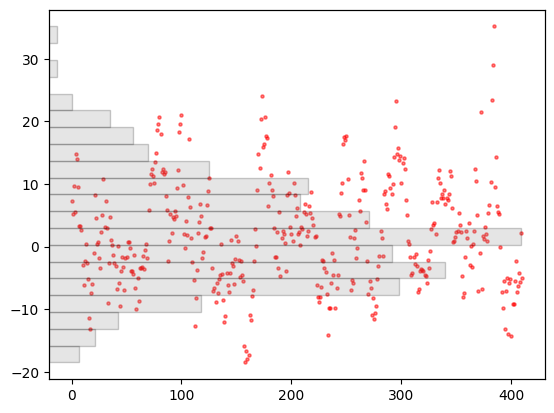

In [ ]:
data_name = '3MA_2M'
model = 'online'

data = datasets[data_name]
theta, y_hat, error = tuple(linear_reg[model][data_name].values())

print(f"RMSE: {np.sqrt(sum(error**2) / len(error))[0]:.4f}%")

#plt.plot(y_hat, label='Prediction')
#plt.plot(data['y'][-len(y_hat):], label='Actual')
plt.scatter(range(len(error)), error, alpha=0.5, s=5, color='red', label='Error')
#plt.title(f'Model Performance vs Error Distribution\nMean: {error.mean():.4f} Std: {error.std():.4f}')
#plt.xlabel('Time Periods (Month)')
#plt.ylabel('YoY Growth (%)')
#plt.legend()

ax2 = plt.twiny()
ax2.hist(error, orientation='horizontal', bins=20, 
         alpha=0.2, color='grey', edgecolor='black')
ax2.xaxis.set_visible(False)

In [ ]:
# define column names for independent variables
x_cols = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

model = LinearRegression()

# predicted %YoY growths after each month based on the last 10 years data
date = df['Date'].iloc[120:].values
est_growth = {'0M': [],'1M': [np.nan], '2M': [np.nan]*2, '3M': [np.nan]*3}
future = {'0M': [], '1M': [], '2M': [], '3M': []}
# test data index

for m in [0,1,2,3]:
    # shift data for each month
    df_shift = df.copy()
    df_shift['SP500'] = df['SP500'].shift(-m)
    # create train and test data
    for i in range(120, len(df)-m):
        # define start index
        s = i - 120
        train = df_shift.iloc[s:i]
        test = df_shift.iloc[i:i+1]

        # define model
        model = LinearRegression()
        # fit the data
        model.fit(train[x_cols], train['SP500'])
        # get and predicted value and store it to dict
        est_growth[f'{m}M'] += list(model.predict(test[x_cols]))
    
    # add the rest of feature(s)
    future[f'{m}M'] += list(model.predict(df_shift.iloc[-m:][x_cols])) 

In [ ]:
result_df = df[['Date', 'SP500']].iloc[120:].reset_index(drop=True)
# add predicted growth
for k in est_growth.keys():
    result_df[f"Est_{k}_Ago"] = est_growth[k]
result_df.head()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
0,1989-01,15.715561,NaN,NaN,NaN
1,1989-02,7.856014,24.660302,NaN,NaN
2,1989-03,13.897786,12.531227,22.899435,NaN
3,1989-04,18.486217,9.114212,11.757725,22.306831
4,1989-05,22.261209,11.153234,8.972035,11.393356


In [ ]:
result_df.tail()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
411,2023-04,0.908772,2.687153,3.438394,2.489983
412,2023-05,1.153883,5.561697,2.336005,4.000293
413,2023-06,17.567590,6.732435,5.110040,3.151268
414,2023-07,11.105029,11.939503,7.009820,5.578984
415,2023-08,13.973708,15.989454,11.825849,7.337735


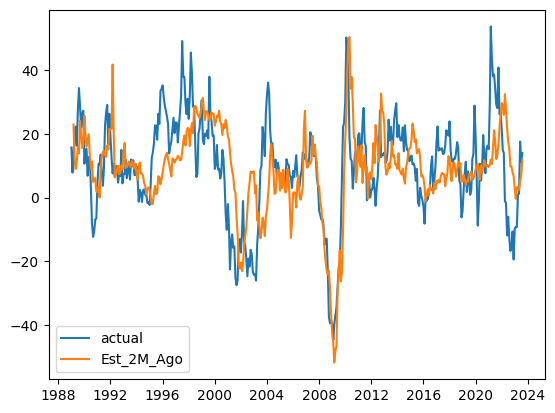

In [ ]:
plt.plot(pd.to_datetime(result_df['Date']), result_df['SP500'], label='actual')
plt.plot(pd.to_datetime(result_df['Date']), result_df['Est_2M_Ago'], label='Est_2M_Ago')
plt.legend()

In [ ]:
future

{'1M': [8.674979625958029],
 '2M': [15.35483201095332, 8.707772307491057],
 '3M': [13.59716455647952, 17.544255000982595, 10.17739639106059]}

In [ ]:
for a, b in zip([3585.620117, 3871.979980, 4080.110107], future):
    growth = (b/100) + 1
    print(a*growth)


3896.671931614002
4209.143180450038
4495.359085781116
